# smrandom seq iM activity
Replicates the processing steps described in the original publication for the CIP time-course single-cell RNA-seq samples.

Gene identifiers from BW25113 are mapped to MG1655 (`b` numbers) using the provided BBH table.Quality-control follows the published cut-offs on total UMIs per time point and retains genes detected in ≥3 cells and cells with ≥10 detected genes.

Downstream, the notebook performs Scanpy normalisation, HVG detection with the reported parameters, PCA (svd_solver='arpack'), neighbours with `n_neighbors=10` and `n_pcs=4`, UMAP, Leiden clustering (resolution=1), and finally infers iModulon activities using the full normalised expression matrix.

In [1]:
# Imports and plotting defaults
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple

try:
    import seaborn as sns
except ImportError:
    sns = None

sc.settings.set_figure_params(dpi=100, facecolor='white')

In [2]:
# File locations and metadata
DATA_DIR = Path('smRandom_csv_matrix')
MAPPING_PATH = Path('BBH/BW25113_MG1655_BBH.tsv')
M_MATRIX_PATH = Path('P1K/P1K_M.csv')

accession_to_time = {
    'CRR794625': 'CIP_0h',
    'CRR794626': 'CIP_1h',
    'CRR794627': 'CIP_2h',
    'CRR794628': 'CIP_4h',
}
condition_order = ['CIP_0h', 'CIP_1h', 'CIP_2h', 'CIP_4h']


In [3]:
# Load BW25113 → MG1655 mapping (using best bidirectional hits)
bw_to_mg = (
    pd.read_csv(MAPPING_PATH, sep='	', usecols=['query_gene_id', 'subject_gene_id'])
    .drop_duplicates(subset='query_gene_id')
    .set_index('query_gene_id')['subject_gene_id']
)
print(f"Loaded {bw_to_mg.size:,} BW25113 → MG1655 gene mappings")


Loaded 4,206 BW25113 → MG1655 gene mappings


In [4]:
# Helper to load one matrix, map to MG1655 genes, and attach metadata
def load_sample(accession: str, time_point: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    matrix_path = DATA_DIR / f"{accession}_filtered_feature_bc_matrix.csv"
    counts = pd.read_csv(matrix_path, index_col=0)

    overlapping = counts.columns.intersection(bw_to_mg.index)
    if overlapping.empty:
        raise ValueError(f'No BW25113 → MG1655 mappings for any genes in {accession}')

    counts = counts.loc[:, overlapping].copy()
    counts.columns = counts.columns.map(bw_to_mg)
    counts = counts.groupby(level=0, axis=1).sum()

    barcodes = counts.index.astype(str)
    cell_ids = pd.Index([f"{accession}_{bc}" for bc in barcodes], name='cell_id')
    counts.index = cell_ids

    obs = pd.DataFrame({
        'accession': accession,
        'time_point': time_point,
        'barcode': barcodes,
    }, index=cell_ids)

    print(f"{accession} ({time_point}): {counts.shape[0]:,} cells × {counts.shape[1]:,} mapped genes")
    return counts, obs


In [5]:
# Load all four samples
counts_list = []
obs_list = []
for accession, time_point in accession_to_time.items():
    counts, obs = load_sample(accession, time_point)
    counts_list.append(counts)
    obs_list.append(obs)

counts_df = pd.concat(counts_list, axis=0).fillna(0)
counts_df = counts_df.astype(np.int32)
obs_df = pd.concat(obs_list, axis=0)

print(f'Combined matrix: {counts_df.shape[0]:,} cells × {counts_df.shape[1]:,} genes before QC filters')


/tmp/ipykernel_1513732/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794625 (CIP_0h): 10,000 cells × 4,186 mapped genes


/tmp/ipykernel_1513732/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794626 (CIP_1h): 10,000 cells × 4,186 mapped genes


/tmp/ipykernel_1513732/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794627 (CIP_2h): 10,000 cells × 4,186 mapped genes


/tmp/ipykernel_1513732/3250542050.py:12: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  counts = counts.groupby(level=0, axis=1).sum()


CRR794628 (CIP_4h): 10,000 cells × 4,186 mapped genes
Combined matrix: 40,000 cells × 4,186 genes before QC filters


Remaining: 25,133 cells × 4,186 genes after QC filters


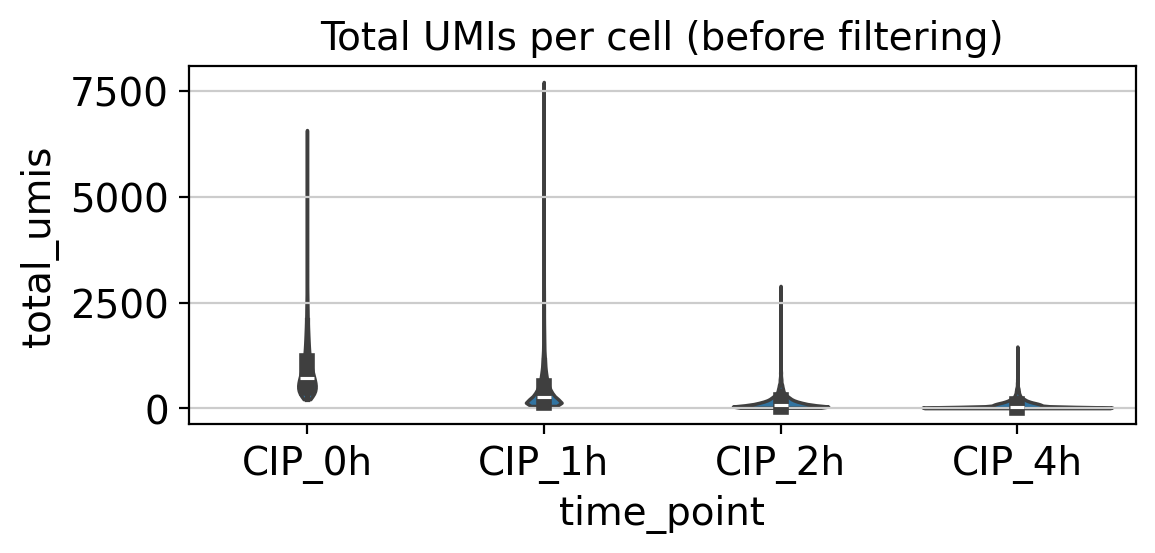

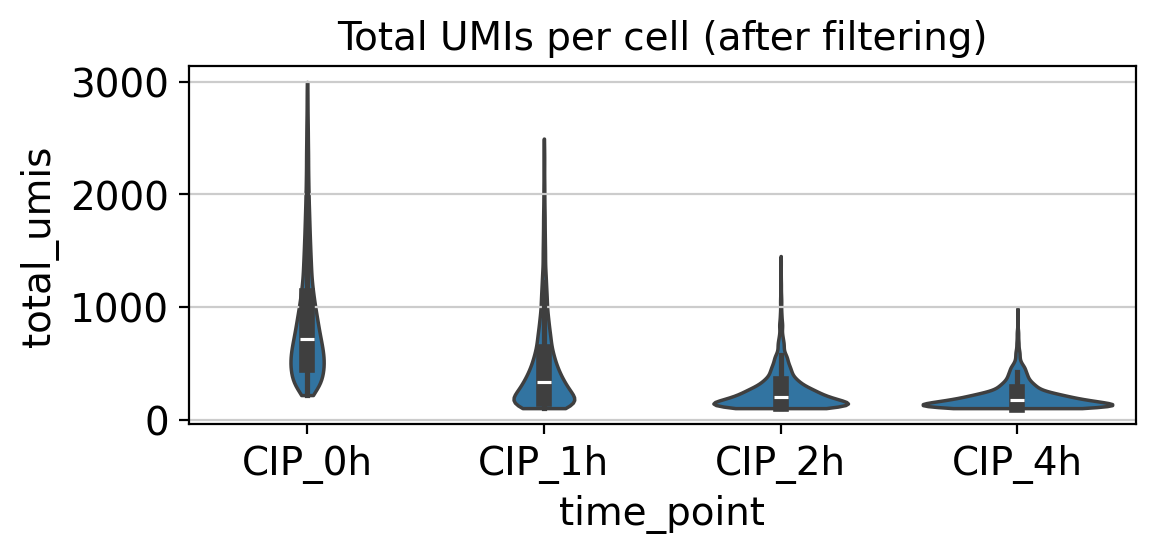

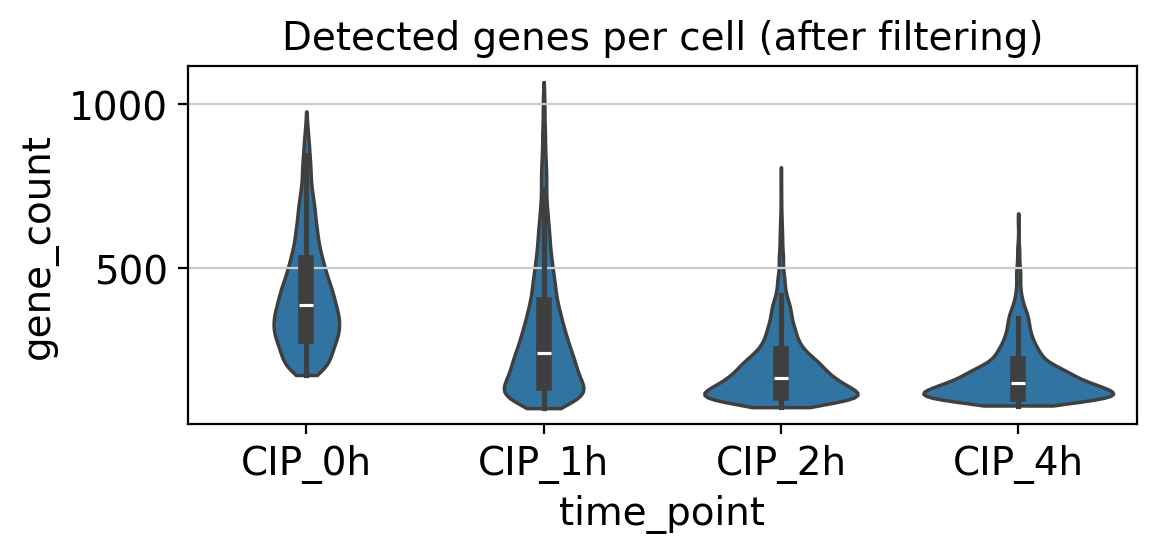

In [6]:
# Published UMI-based QC filters
obs_df['total_umis'] = counts_df.sum(axis=1)
obs_df['time_point'] = pd.Categorical(obs_df['time_point'], categories=condition_order, ordered=True)

if sns is not None:
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=obs_df, x='time_point', y='total_umis', cut=0)
    plt.title('Total UMIs per cell (before filtering)')
    plt.tight_layout()
else:
    print('Install seaborn to reproduce violin plots of UMI distributions.')

mask = (obs_df['total_umis'] > 100) & (obs_df['total_umis'] < 3000)
obs_df = obs_df.loc[mask]
counts_df = counts_df.loc[obs_df.index]

max_umi_thresholds = {'CIP_2h': 1500, 'CIP_1h': 2500, 'CIP_4h': 1000}
for time_point, max_umis in max_umi_thresholds.items():
    to_keep = ~((obs_df['time_point'] == time_point) & (obs_df['total_umis'] > max_umis))
    obs_df = obs_df.loc[to_keep]
    counts_df = counts_df.loc[obs_df.index]

obs_df['gene_count'] = (counts_df > 0).sum(axis=1)

if sns is not None:
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=obs_df, x='time_point', y='total_umis', cut=0)
    plt.title('Total UMIs per cell (after filtering)')
    plt.tight_layout()
    plt.figure(figsize=(6, 3))
    sns.violinplot(data=obs_df, x='time_point', y='gene_count', cut=0)
    plt.title('Detected genes per cell (after filtering)')
    plt.tight_layout()

print(f'Remaining: {counts_df.shape[0]:,} cells × {counts_df.shape[1]:,} genes after QC filters')


In [7]:
# Create AnnData object and align with P1K M matrix genes
var = pd.DataFrame(index=counts_df.columns, data={'mg1655_gene': counts_df.columns})
adata = ad.AnnData(X=counts_df.to_numpy(dtype=np.float32), obs=obs_df, var=var)
adata.obs['time'] = adata.obs['time_point'].astype(str)
adata.obs_names.name = 'cell_id'
adata.var_names.name = 'mg1655_gene'
adata.layers['counts'] = adata.X.copy()
adata.var_names_make_unique()

M = pd.read_csv(M_MATRIX_PATH, index_col=0)
shared_genes = adata.var_names.intersection(M.index, sort=False)
if shared_genes.empty:
    raise ValueError('No genes overlap between the single-cell data and the P1K iModulon M matrix')

adata = adata[:, shared_genes].copy()
adata.layers['counts'] = adata.X.copy()
M = M.loc[shared_genes]
print(f"Aligned AnnData: {adata.n_obs:,} cells × {adata.n_vars:,} shared genes")


Aligned AnnData: 25,133 cells × 4,095 shared genes


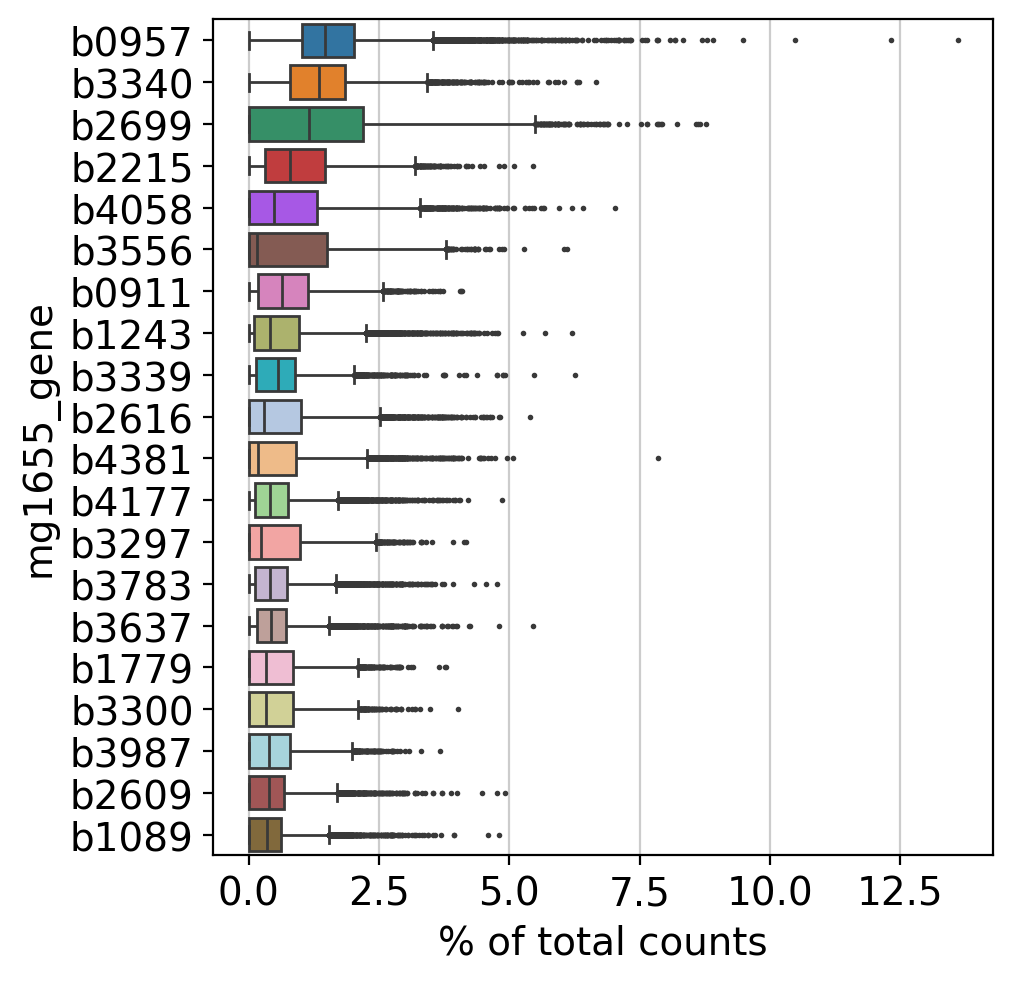

In [8]:
# Highest expressed genes across cells
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
# Low-quality cell/gene filtering
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=3)
M = M.loc[adata.var_names]
print(f"Post-filtering: {adata.n_obs:,} cells × {adata.n_vars:,} genes")


Post-filtering: 25,133 cells × 4,095 genes


In [10]:
# Normalisation and log-transformation
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log_normalized'] = adata.X.copy()
adata.raw = adata


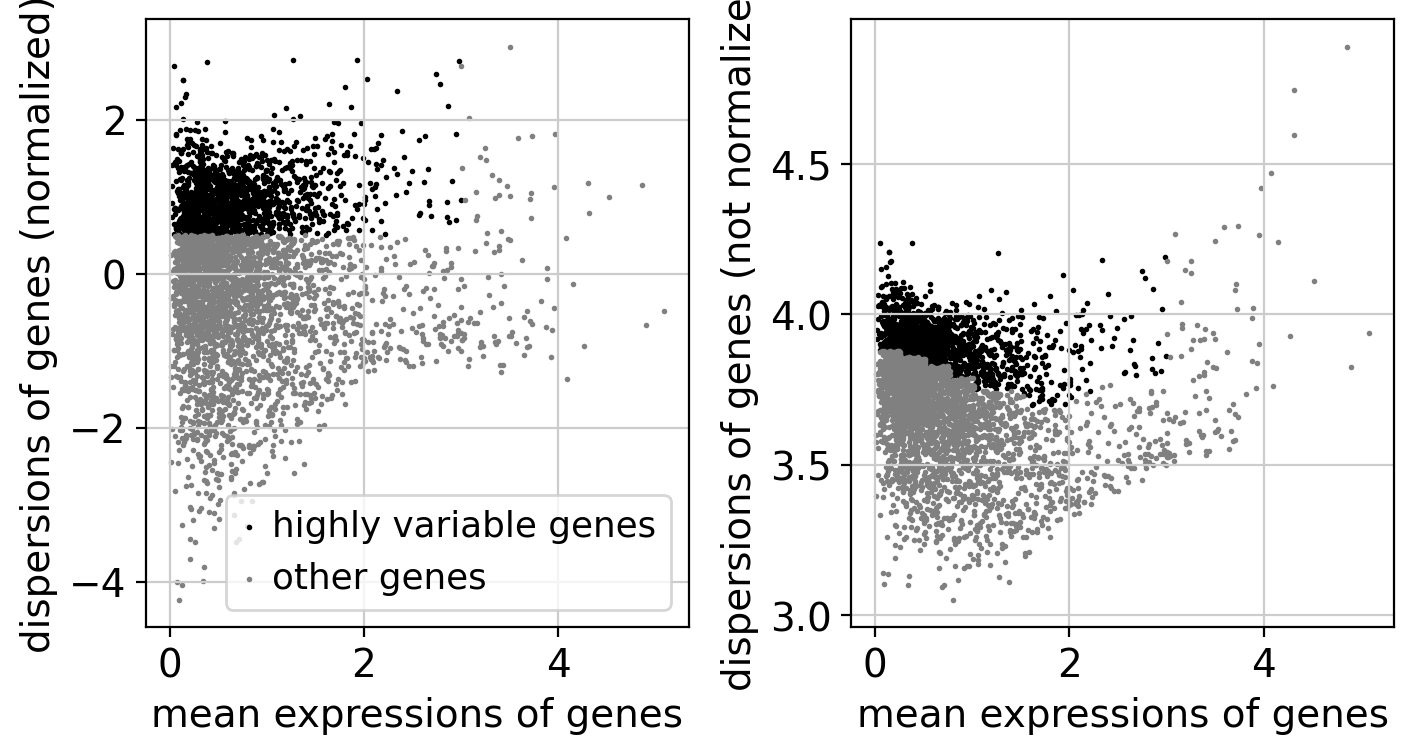

In [11]:
# Highly variable genes (paper parameters)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


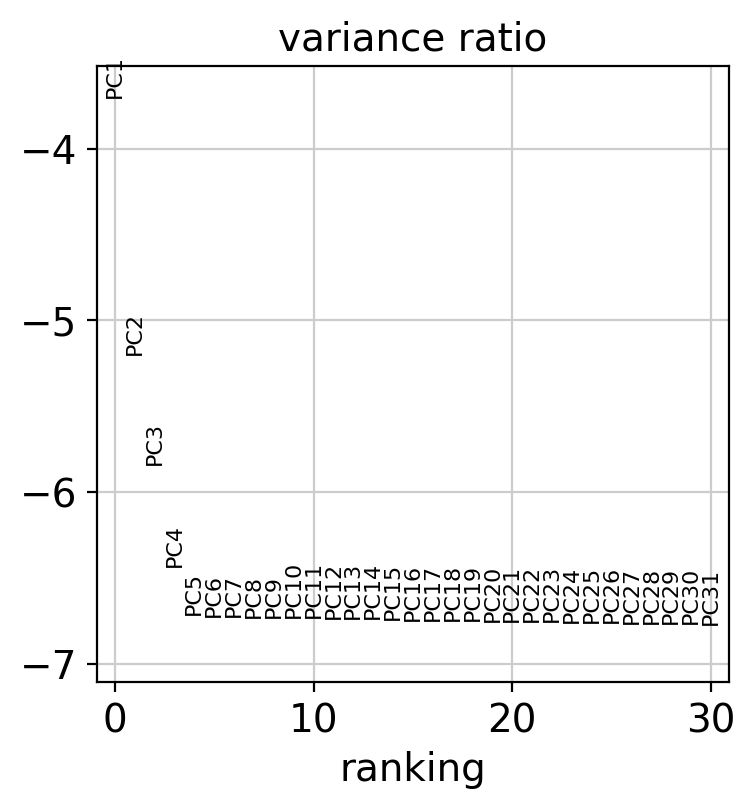

In [12]:
# Scaling, PCA, and variance explained
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)


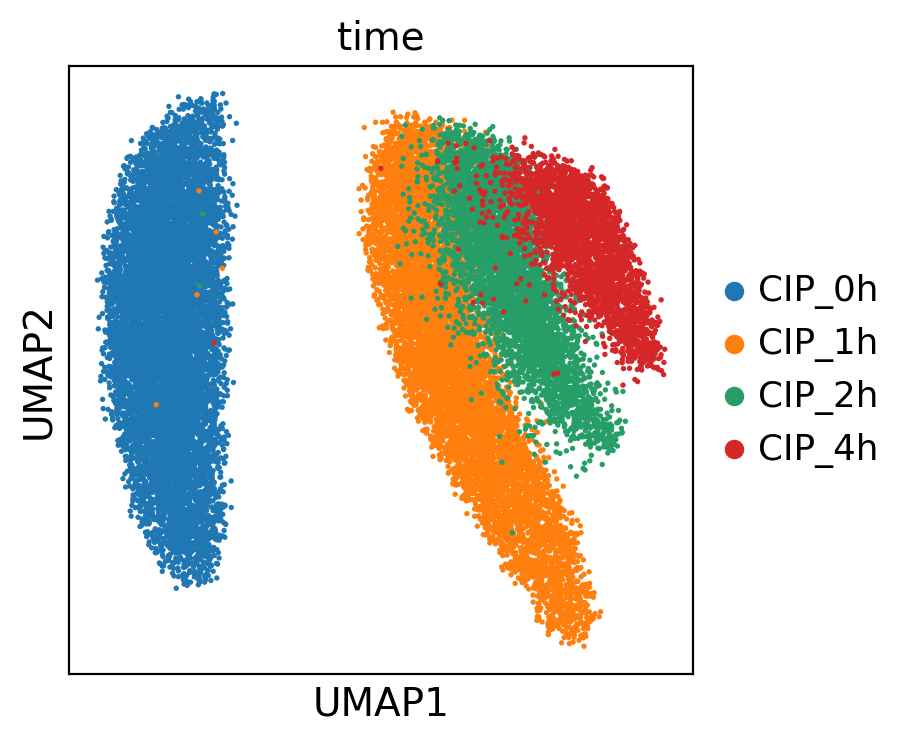

/tmp/ipykernel_1513732/2287368363.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0)


In [13]:
# Neighbour graph, UMAP, and Leiden clustering
n_pcs = min(10, adata.obsm['X_pca'].shape[1])
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=n_pcs)
sc.tl.umap(adata, min_dist=0.7, spread=0.5)
sc.pl.umap(adata, color='time', size=15)
sc.tl.leiden(adata, resolution=1.0)
# 

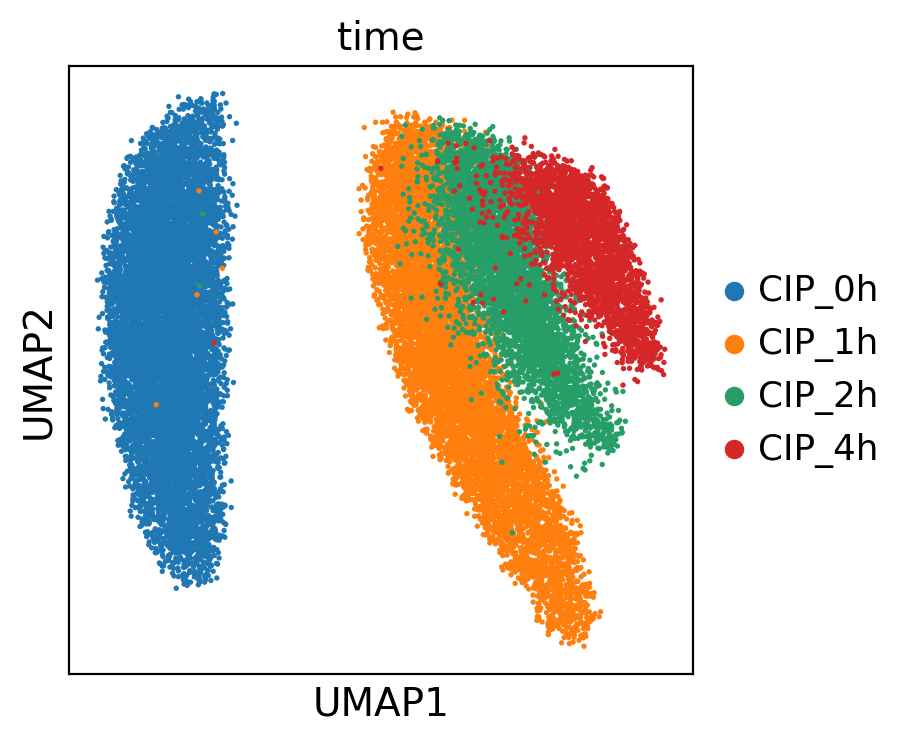

In [14]:
sc.pl.umap(adata, color='time', size=15)

In [15]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from matplotlib.collections import PathCollection
from matplotlib.figure import Figure
from typing import Optional, Tuple


def save_umap_time(
    adata,
    save_path: Optional[str] = None,
    font_path: str = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    figsize: Tuple[float, float] = (6, 5),
    size: int = 15,
):
    """
    Produce sc.pl.umap(adata, color='time'), remove title, apply Arial font to all text
    (axes, ticks, legend), show it, and optionally save with rasterized scatter.
    """

    font_prop = fm.FontProperties(fname=font_path)

    CIP_COLOR_MAP = {
        "CIP_0h": "#3F9AAE",
        "CIP_1h": "#79C9C5",
        "CIP_2h": "#FFE2AF",
        "CIP_4h": "#F96E5B",
    }

    if "time" in adata.obs:
        if hasattr(adata.obs["time"].dtype, "categories"):
            categories = list(adata.obs["time"].cat.categories)
        else:
            categories = list(pd.unique(adata.obs["time"].astype(str)))
        adata.uns["time_colors"] = [CIP_COLOR_MAP.get(cat, "#4C72B0") for cat in categories]

    # Create plot with controlled figsize
    with plt.rc_context({"figure.figsize": figsize}):
        fig = sc.pl.umap(
            adata,
            color="time",
            size=size,
            show=False,
            return_fig=True,
        )

    # Scanpy may return (fig, ax_list)
    if isinstance(fig, tuple):
        fig = fig[0]
    if not isinstance(fig, Figure):
        raise TypeError(f"Unexpected object returned: {type(fig)}")

    # Axes text: labels, ticks, embedded texts
    for ax in fig.axes:
        # Remove title ("time")
        ax.set_title("Time")

        # Axis labels (UMAP1 / UMAP2)
        xlab = ax.get_xlabel()
        ylab = ax.get_ylabel()
        if xlab:
            ax.set_xlabel(xlab, fontproperties=font_prop)
        if ylab:
            ax.set_ylabel(ylab, fontproperties=font_prop)

        # Tick labels
        for tick in ax.get_xticklabels() + ax.get_yticklabels():
            tick.set_fontproperties(font_prop)

        # Any text objects inside the axis
        for txt in ax.texts:
            txt.set_fontproperties(font_prop)

        # Legend attached to this axis (for categorical "time")
        leg = ax.get_legend()
        if leg is not None:
            # Legend title
            leg_title = leg.get_title()
            if leg_title is not None:
                leg_title.set_fontproperties(font_prop)
            # Legend labels
            for txt in leg.get_texts():
                txt.set_fontproperties(font_prop)

    # Also handle figure-level legends if any
    for leg in fig.legends:
        leg_title = leg.get_title()
        if leg_title is not None:
            leg_title.set_fontproperties(font_prop)
        for txt in leg.get_texts():
            txt.set_fontproperties(font_prop)

    # Show in notebook
    fig.show()

    # Save and rasterize scatter points only
    if save_path is not None:
        for ax in fig.axes:
            for coll in ax.collections:
                if isinstance(coll, PathCollection):
                    coll.set_rasterized(True)
        fig.savefig(save_path, bbox_inches="tight")

    return fig


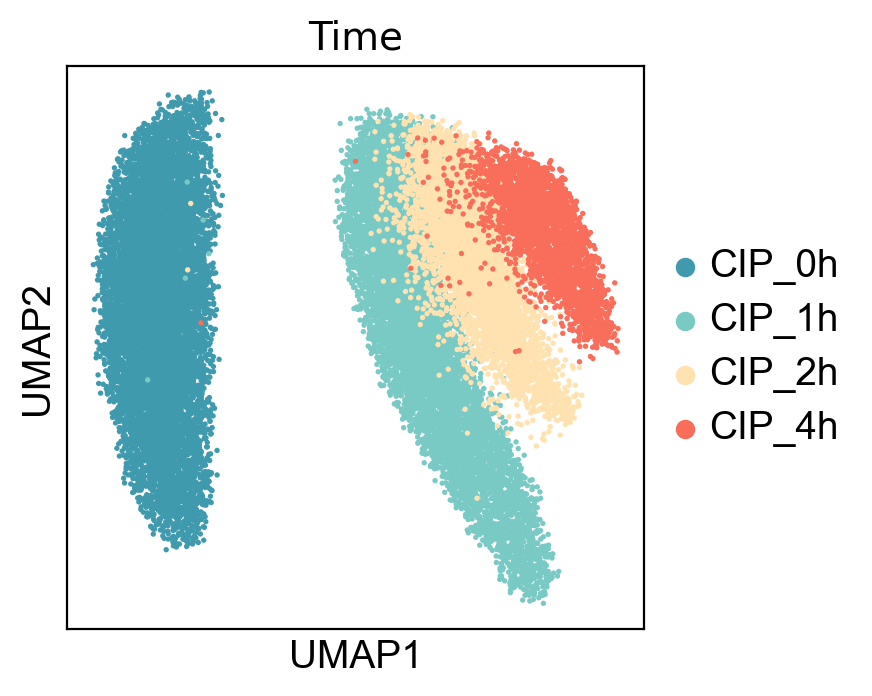

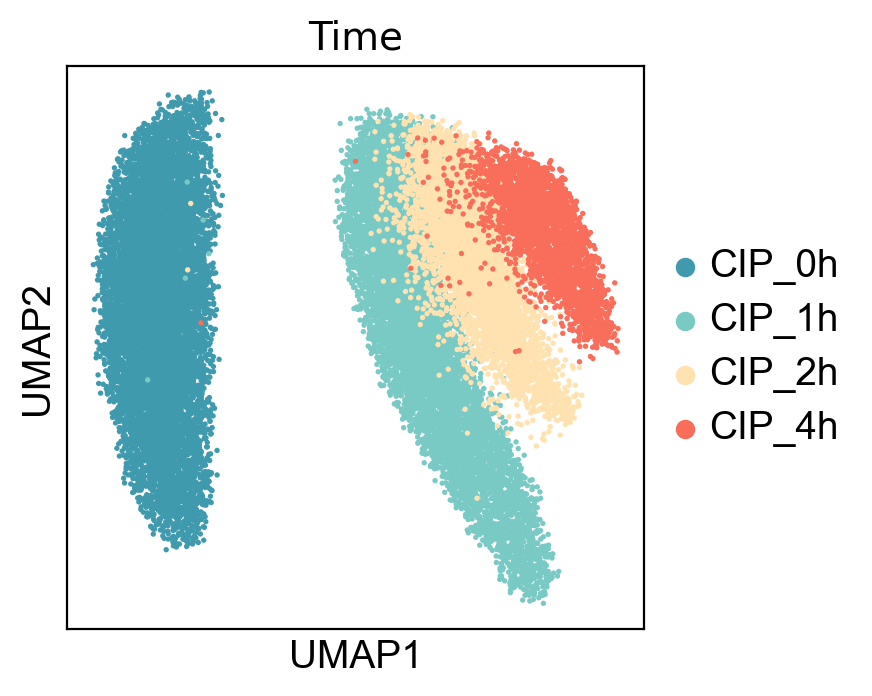

In [16]:
save_umap_time(
    adata,
    save_path="umap_time.svg",
    figsize=(3.7, 3.7),
    size=15,
)

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from typing import Optional, Sequence, Tuple

from scipy.stats import mannwhitneyu


def plot_imodulon_activity_violin_grid(
    adata_obj: ad.AnnData,
    imodulon_names: Sequence[str],
    condition_col: str = "time_point",
    condition_order: Optional[Sequence[str]] = None,
    palette_key: str = "time",
    fig_width: float = 10.0,
    row_height: float = 2.0,
    font_path: str = "/usr/share/fonts/truetype/msttcorefonts/Arial.ttf",
    save_path: Optional[str] = None,
    plot_kind: str = "violin",
    # --- significance annotation options ---
    show_significance: bool = True,
    alpha: float = 0.05,
    test: str = "mwu",  # "mwu" (Mann–Whitney U) or "ttest" (Welch t-test)
    stars_for_ns: bool = False,  # if False, suppress "ns"
    compare_to_first: bool = True,  # if True, compare col2/3/4/... to col1
    compare_pairs: Optional[Sequence[Tuple[str, str]]] = None,  # overrides compare_to_first if provided
) -> plt.Figure:
    """
    Plot iModulon activity violins or boxplots in a grid.

    Each row is an iModulon; within a row, all conditions are drawn in one axis.
    Optional significance brackets (with stars) are computed per row.
    """

    if "iModulon_activity" not in adata_obj.obsm or "iModulon_names" not in adata_obj.uns:
        raise KeyError("Run activity inference before plotting iModulon activities")

    imodulon_names = list(imodulon_names)
    imod_names = list(adata_obj.uns["iModulon_names"])
    missing = [name for name in imodulon_names if name not in imod_names]
    if missing:
        raise ValueError(f"Unknown iModulon name(s): {', '.join(missing)}")

    obs = adata_obj.obs
    obs_conditions = obs[condition_col].astype(str)

    if condition_order is None:
        candidate_orders = [
            ["CIP_0h", "CIP_1h", "CIP_2h", "CIP_4h"],
        ]
        for candidate in candidate_orders:
            if set(candidate).issubset(set(obs_conditions)):
                condition_order = candidate
                break

    if condition_order is None:
        if hasattr(obs[condition_col].dtype, "categories"):
            condition_order = list(obs[condition_col].cat.categories)
        else:
            condition_order = list(pd.unique(obs_conditions))

    condition_order = list(condition_order)

    def _display_label(label: str) -> str:
        return label.replace("_", " ")

    palette = {}
    palette_key_name = f"{palette_key}_colors"
    if palette_key_name in adata_obj.uns and palette_key in obs:
        palette_vals = list(adata_obj.uns[palette_key_name])
        if hasattr(obs[palette_key].dtype, "categories"):
            palette_labels = list(obs[palette_key].cat.categories)
        else:
            palette_labels = list(pd.unique(obs[palette_key].astype(str)))
        palette = {label: color for label, color in zip(palette_labels, palette_vals)}

    default_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", ["#4C72B0"])

    plot_kind = plot_kind.lower().strip()
    if plot_kind not in {"violin", "box"}:
        raise ValueError("plot_kind must be 'violin' or 'box'")

    test = test.lower().strip()
    if test not in {"mwu", "ttest"}:
        raise ValueError("test must be 'mwu' or 'ttest'")

    def _p_to_stars(p: float) -> str:
        if p < 1e-4:
            return "****"
        if p < 1e-3:
            return "***"
        if p < 1e-2:
            return "**"
        if p < alpha:
            return "*"
        return "ns"

    def _pair_pvalue(x: np.ndarray, y: np.ndarray) -> float:
        x = np.asarray(x)
        y = np.asarray(y)
        x = x[np.isfinite(x)]
        y = y[np.isfinite(y)]
        if x.size < 2 or y.size < 2:
            return np.nan
        if test == "mwu":
            return mannwhitneyu(x, y, alternative="two-sided").pvalue
        # Welch t-test
        from scipy.stats import ttest_ind
        return ttest_ind(x, y, equal_var=False, nan_policy="omit").pvalue

    def _add_sig_bracket(
        ax: plt.Axes,
        x1: float,
        x2: float,
        y: float,
        h: float,
        text: str,
        font_prop: fm.FontProperties,
    ) -> None:
        ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color="black", lw=1.0, clip_on=False)
        ax.text(
            (x1 + x2) / 2.0,
            y + h - 3 * h,
            text,
            ha="center",
            va="bottom",
            fontproperties=font_prop,
            fontsize=10,
            clip_on=False,
        )

    # Decide which pairs to compare (default: compare each later condition to the first)
    if compare_pairs is None:
        if compare_to_first and len(condition_order) >= 2:
            ref = str(condition_order[0])
            compare_pairs = [(ref, str(condition_order[i])) for i in range(1, len(condition_order))]
        else:
            compare_pairs = []
    else:
        compare_pairs = list(compare_pairs)

    n_rows = len(imodulon_names)
    fig, axes = plt.subplots(
        n_rows,
        1,
        figsize=(fig_width, row_height * n_rows),
        squeeze=False,
        sharex=True,
        gridspec_kw={"hspace": 0.0},
    )

    font_prop = fm.FontProperties(fname=font_path)
    activity = adata_obj.obsm["iModulon_activity"]

    positions = list(range(1, len(condition_order) + 1))
    cond_to_pos = {str(c): positions[i] for i, c in enumerate(condition_order)}

    for row_idx, imod_name in enumerate(imodulon_names):
        ax = axes[row_idx, 0]
        imod_idx = imod_names.index(imod_name)
        values = activity[:, imod_idx]

        data_by_condition = []
        by_cond = {}
        for condition in condition_order:
            mask = obs_conditions == str(condition)
            vals = np.asarray(values[mask])
            data_by_condition.append(vals)
            by_cond[str(condition)] = vals

        if plot_kind == "violin":
            parts = ax.violinplot(
                data_by_condition,
                positions=positions,
                widths=0.8,
                showmedians=True,
                showextrema=False,
            )
            for idx, (body, condition) in enumerate(zip(parts["bodies"], condition_order)):
                color = palette.get(condition, default_colors[idx % len(default_colors)])
                body.set_facecolor(color)
                body.set_edgecolor("black")
                body.set_alpha(0.85)
            if "cmedians" in parts:
                parts["cmedians"].set_edgecolor("black")
        else:
            box = ax.boxplot(
                data_by_condition,
                positions=positions,
                widths=0.6,
                patch_artist=True,
                showfliers=False,
            )
            for idx, (patch, condition) in enumerate(zip(box["boxes"], condition_order)):
                color = palette.get(condition, default_colors[idx % len(default_colors)])
                patch.set_facecolor(color)
                patch.set_edgecolor("black")
                patch.set_alpha(0.85)
            for element in ("whiskers", "caps", "medians"):
                for artist in box[element]:
                    artist.set_color("black")

        ax.set_ylabel(imod_name, fontproperties=font_prop)
        ax.grid(False)

        # Spines: right edge on; shared horizontal edges without double-thick line
        ax.spines["left"].set_visible(True)
        ax.spines["right"].set_visible(True)
        ax.spines["bottom"].set_visible(True)
        ax.spines["top"].set_visible(row_idx == 0)

        for label in ax.get_yticklabels():
            label.set_fontproperties(font_prop)

        # --- significance brackets per row ---
        if show_significance and len(compare_pairs) > 0:
            finite_groups = [v[np.isfinite(v)] for v in by_cond.values() if v.size > 0]
            all_vals = np.concatenate(finite_groups) if len(finite_groups) > 0 else np.array([])
            if all_vals.size > 0:
                y_max = float(np.nanmax(all_vals))
                y_min = float(np.nanmin(all_vals))
                y_span = (y_max - y_min) if (y_max > y_min) else 1.0

                base_y = y_max + 0.08 * y_span
                step = 0.10 * y_span
                h = 0.03 * y_span

                k = 0
                for (c1, c2) in compare_pairs:
                    c1 = str(c1)
                    c2 = str(c2)
                    if c1 not in cond_to_pos or c2 not in cond_to_pos:
                        continue

                    p = _pair_pvalue(by_cond.get(c1, np.array([])), by_cond.get(c2, np.array([])))
                    if not np.isfinite(p):
                        continue

                    stars = _p_to_stars(p)
                    if (stars == "ns") and (not stars_for_ns):
                        continue

                    x1 = cond_to_pos[c1]
                    x2 = cond_to_pos[c2]
                    y = base_y + k * step
                    _add_sig_bracket(ax, x1, x2, y, h, stars, font_prop)
                    k += 1

                ax.set_ylim(top=base_y + max(k, 1) * step + 0.12 * y_span)

        if row_idx != n_rows - 1:
            ax.set_xticks([])
        else:
            ax.set_xticks(positions)
            ax.set_xticklabels([_display_label(c) for c in condition_order], fontproperties=font_prop)

    fig.subplots_adjust(left=0.12, right=0.98, top=0.98, bottom=0.08, hspace=0.0)

    if save_path is not None:
        fig.savefig(save_path, bbox_inches="tight")
    return fig


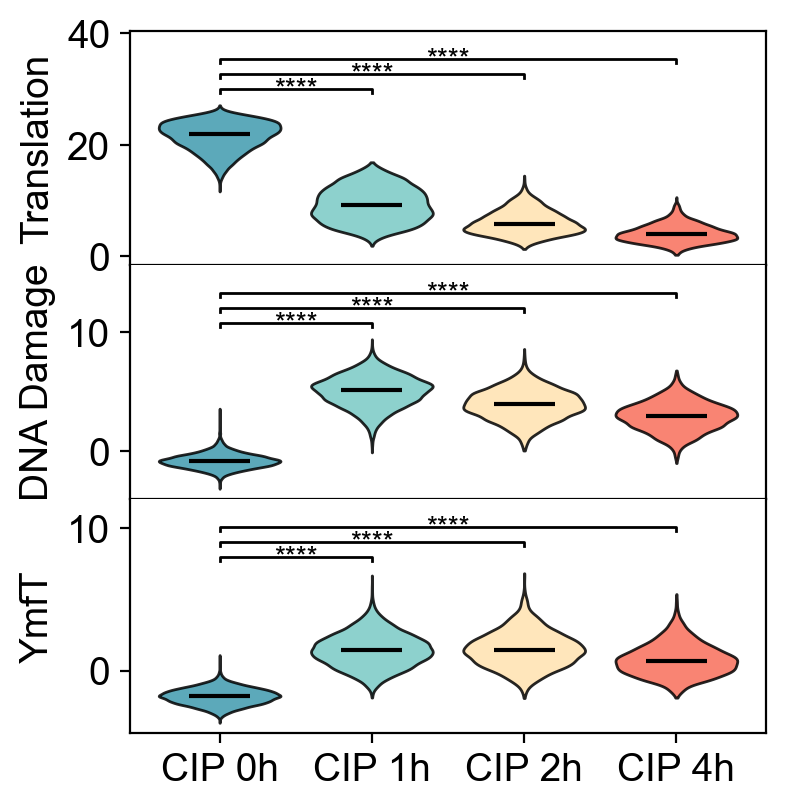

In [69]:
imodulons = ["Translation", "DNA Damage","YmfT"] 
fig = plot_imodulon_activity_violin_grid(
    adata,
    imodulons,
    condition_col="time_point",
    fig_width=3.7,
    row_height=1.3,
    save_path="imodulon_activity_violin_stress.svg",
)

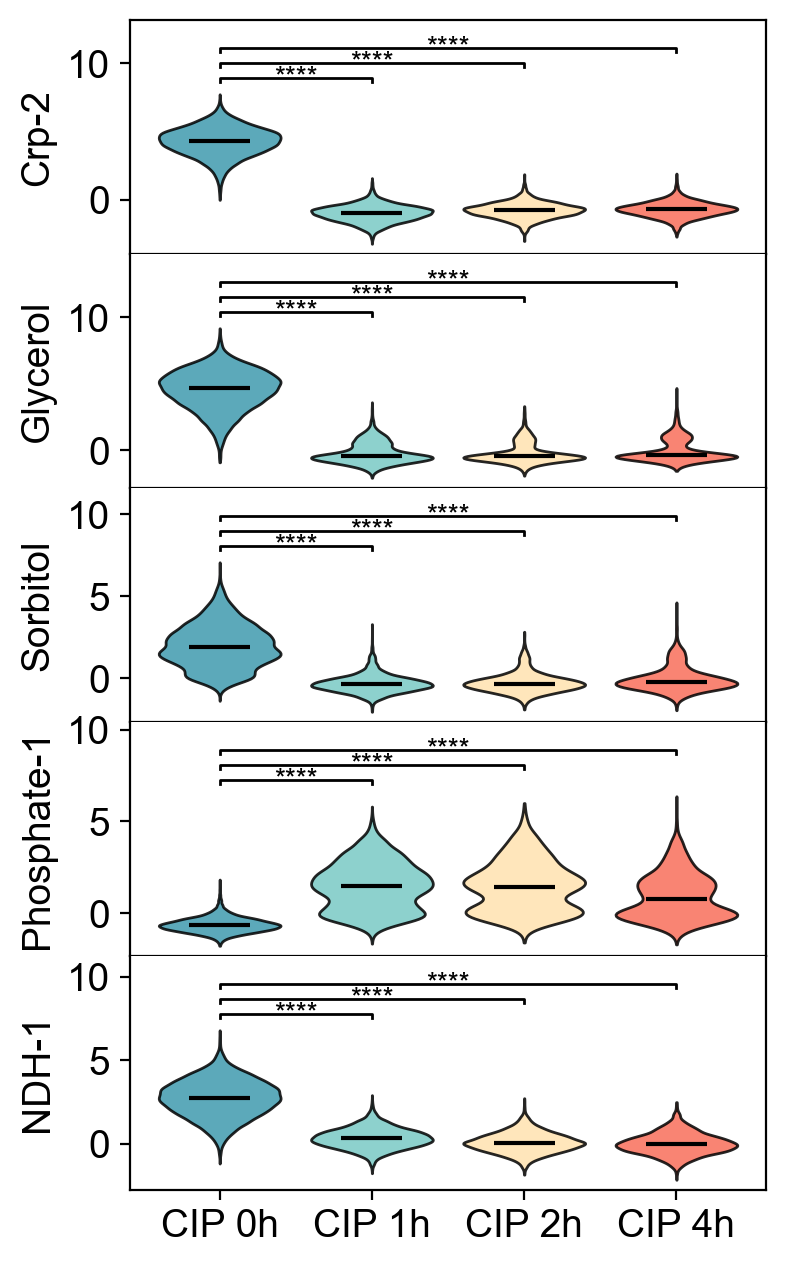

In [70]:
imodulons = ["Crp-2", "Glycerol", "Sorbitol","Phosphate-1","NDH-1"] 
fig = plot_imodulon_activity_violin_grid(
    adata,
    imodulons,
    condition_col="time_point",
    fig_width=3.7,
    row_height=1.3,
    save_path="imodulon_activity_violin_metabolism.svg",
)


In [ ]:
imodulons = ["Crp-2", "Sorbitol", "Phosphate-2", "Glycine", "NDH-1"] 
fig = plot_imodulon_activity_violin_grid(
    adata,
    imodulons,
    condition_col="time_point",
    fig_width=3.7,
    row_height=1.3,
    save_path="imodulon_activity_violin_metabolism_supp.svg",
)